## Process shadow tomography

Process shadows generalize the classical shadows frame work to quantum processes: Instead of classical shadows $\hat{\rho}$ of quantum states $\rho$, we consider classical shadows of quantum process or quantum channels $\mathcal{E}:\rho_i\to \rho_f=\mathcal{E}(\rho_i)$. Such process shadows have been introduced and discussed in various works [Kunjummen et al, Phys. Rev. A 107, 042403 (2023)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.042403), 
  [Levy,et al Phys. Rev. Research 2024](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029). 

In this tutorial, we will represent $\mathcal{E}$ as a Choi Matrix $\Lambda$ using the isomorphism $$\Lambda = \sum_{\xi',\xi}\ket{\xi'}\bra{\xi}\otimes \mathcal{E}(\ket{\xi'}\bra{\xi})$$ and build process shadows $\hat{\Lambda}$ that satisfy $E[\hat \Lambda]=\Lambda$.

In [1]:
using ProgressMeter
using ITensors
using RandomMeas

We compute the exact Choi matrix by evolving the unnormalized density matrix $\rho_0=[\sum_{\xi'}\ket{\xi'}^{\otimes 2}][\sum_{\xi}\bra{\xi}^{\otimes 2}]$ representing a Bell state between two copies on the $N$ qubit system. We then have $\Lambda= (1\otimes\mathcal{E})(\rho_0)$. We consider the quantum channel $\mathcal{E}_0$ generated by an ideal quantum circuit, and the quantum channel $\mathcal{E}$ of a noisy quantum circuit.

In [2]:
N = 2 # number of qubits
depth = 2 # circuit depth

ξ = siteinds("Qubit", N;addtags="output") # output indices of the choi matrix
s = siteinds("Qubit", N;addtags="input") # input indices of the choi matrix

#Create a Bell-State density matrix on two copies of the system
ρ0 = MPO(ξ)
for i in 1:N
    ρ0[i] = δ(s[i],ξ[i])*δ(s[i]',ξ[i]')
end

circuit    = random_circuit(ξ, depth)
Λ0 = apply(circuit,ρ0,apply_dag=true); # We apply the unitary circuit to the density matrix to one copy (i.e.\ compute  rho = (1 \otimes E_0)(rho_0) )

p  = 0.2*rand(N)
Λ = apply_depo_channel(Λ0,p); # We apply noise to the output density matrix of the ideal circuit (i.e.\ compute (1 \otimes E)(rho_0) )


Our aim is to estimate the process fidelity $\mathcal{F}=\frac{1}{4^N}\braket{\Lambda|\Lambda_0}$, where $\braket{.|.}$ is the inner product. Note: this expression holds because $\Lambda_0$ is a unitary channel, otherwise one would need to use a more complicated expression.

In [3]:
F = real(inner(Λ,Λ0)/4^N)
println(" -- Process Fidelity ", F)

 -- Process Fidelity 0.9527181601231951


To construct classical shadows $\hat \Lambda$  of $\Lambda$, we prepare random initial states, evolve them with the (noisy) circuit and perform measurements in an random basis. Here, the choice of random initial state and random measurement basis are independent.

Specifically, given a random initial state $U_i^\dag\ket{0}^{\otimes N}$ and outcome bitstring $s$  of a computational basis measurment performed after a random rotation $U_f$ (both $U_i$, $U_f$ being single qubit Haar random rotations), then the following process shadow can be constructed [Eq (B2) in  [Levy,et al Phys. Rev. Research 2024](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.013029)] 

$$\hat{\Lambda}=2^N\mathcal{M}^{-1}([U_i^\dag\ket{0}^{\otimes N}\bra{0}U_i]^T) \otimes \mathcal{M}^{-1}(U_f^\dag\ket{s}^{\otimes N}\bra{s}U_f)$$ 

In order to reduce statistical errors, we also utilize the knowledge of the ideal process $\Lambda_0$ and use the concept of common randomized measurements [Vermersch, al, PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352). We built CRM process shadows as
$$\hat{\Lambda}_{\text{CRM}}=\hat{\Lambda}-\hat{\Lambda}_0+\Lambda_0$$
where $\hat{\Lambda}_0$ is a classical shadow of the Choi matrix $\Lambda_0$ of the ideal circuit, constructed on the classical computer using the same random initial states and measurement basis as in the experiment. When $\Lambda\approx \Lambda_0$ (i.e.\ weak noise), $\hat{\Lambda}_0$ and $\hat{\Lambda}$  are strongly correlated and  CRM shadows $\hat{\Lambda}_{\text{CRM}}$ are much loss prone to statistical errors. Importantly, in any case, they are unbiased estimator of the unknown Choi matrix $\Lambda$.

In [4]:
ITensors.disable_warn_order()

nu = 1000
NM = 5000
states = ["Dn" for n in 1:N]
ψ  = MPS(ComplexF64,ξ,states)
ρ = outer(ψ',ψ)
data = zeros(Int,(NM,N))
Λs = ITensor(vcat(ξ,ξ',s,s'))
Fs = zeros(Float64,nu)

#construct the projector |0><0|, which will be useful to build the process shadow below
P0 = flatten([state(ξ_i,"Dn") for ξ_i in ξ])

Λs_CRM = ITensor(vcat(ξ,ξ',s,s'))
Fs_CRM = zeros(Float64,nu)

@showprogress dt=1 for r in 1:nu   
        ui = get_rotations(ξ,"Haar") #Haar rotations for the initial state preparation
        uid = [swapinds(dag(ui[i]),ξ[i],ξ[i]') for i in 1:N] #We compute u_i^\dag

        uf = get_rotations(ξ,"Haar") #Haar rotations in A
        ### Quantum Measurements
        ρu = apply(uid,ρ,apply_dag=true)
        ρe = apply(circuit,ρu,apply_dag=true)
        ρen = apply_depo_channel(ρe,p)

        #Build shadow for the initial state. Here we use Eq (B2) in using Eq (B2)
        ρi = get_shadow(P0,ξ,ui)
        replaceinds!(ρi,ξ',s) #Final transposition
        replaceinds!(ρi,ξ,s')

        #Build shadow for the final state
        data = get_RandomMeas(ρen,uf,NM,"dense")
        P = get_Born(data,ξ)
        ρf = get_shadow(P,ξ,uf)

        #Form process shadow
        Λt = 2^N*ρi*ρf
        Λs += Λt

        Fs[r] = real(inner(Λs,flatten(Λ0))/2^(2*N))/r
        
        ## CRM part ##
        P = get_Born(apply(uf,ρe,apply_dag=true)) #Simulate RM on the ideal channel
        ρf = get_shadow(P,ξ,uf)
        Λt_CRM = Λt-2^N*ρi*ρf+flatten(Λ0)
        Λs_CRM += Λt_CRM
        Fs_CRM[r] = real(inner(Λs_CRM,flatten(Λ0))/2^(2*N))/r
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


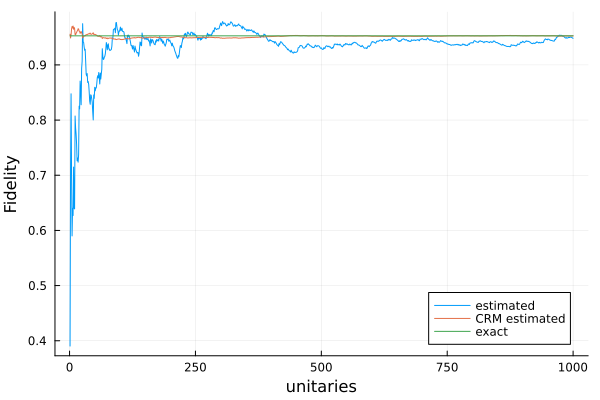

In [7]:
using Plots
plot(1:nu,Fs,label="estimated")
plot!(1:nu,Fs_CRM,label="CRM estimated")
plot!(1:nu,F*ones(nu),label="exact")

ylabel!("Fidelity")
xlabel!("unitaries")